In [1]:
from albumentations.core.transforms_interface import ImageOnlyTransform
from albumentations import *
from albumentations.pytorch import ToTensorV2
import numpy as np
from skimage.color import rgb2hed, hed2rgb
import numbers
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
import sys
from villi_augment import *
from UNet_villi import *
import matplotlib.pyplot as plt
import os
from torch.utils.data import DataLoader
import skimage
from torchmetrics.classification import BinaryConfusionMatrix, ConfusionMatrix
from tensorboardX import SummaryWriter
import time
import datetime
from tqdm import tqdm
import math
import torchinfo
from sklearn.metrics import f1_score # Import F1 score function

In [2]:
class Dataset(object): 
    def __init__(self, fname, device, transforms=None, edge_weight=False): 
        self.fname = fname
        self.edge_weight = edge_weight
        self.device = device
        self.transforms = transforms
        
        with tables.open_file(self.fname) as db:
            self.numpixels = db.root.numpixels[:]
            self.nitems = db.root.img.shape[0]
            
    def __getitem__(self, index):
        with tables.open_file(self.fname, 'r') as db:
            img = db.root.img[index]
            mask = db.root.mask[index]

        if self.transforms:
            transforms = self.transforms()
            augmented = transforms(image=img, mask=mask)
            img = augmented['image']
            mask = augmented['mask']

        if self.edge_weight:
            eweight = skimage.morphology.binary_dilation(mask > 0, skimage.morphology.square(5)) & ~mask

        else: 
            eweight = np.ones(mask.shape, dtype=mask.dtype)
            
        if img.dtype == 'uint8':
            img = img / 255

        return torch.from_numpy(img).permute(2, 0, 1), torch.from_numpy(mask), torch.from_numpy(eweight)
    
    def __len__(self):
        return self.nitems


class Criterion(nn.Module):
    def __init__(self, class_weight, edge_weight):
        super(Criterion, self).__init__()
        self.critCEntropy = nn.CrossEntropyLoss(weight=class_weight, ignore_index=-100, reduction='none')
        self.edge_weight = edge_weight
        self.class_weight = class_weight

    def forward(self, x_pred, y, y_weight):
        loss_matrix = self.critCEntropy(x_pred, y)
        lossCEntropy = (loss_matrix * (self.edge_weight ** y_weight)).mean()
        return (lossCEntropy,)


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent+.00001)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))


total params: 	487307
Layer (type:depth-idx)                        Output Shape              Param #
UNet                                          [1, 3, 1024, 1024]        --
├─ModuleList: 1-1                             --                        --
│    └─UNetConvBlock: 2-1                     [1, 8, 1024, 1024]        --
│    │    └─Sequential: 3-1                   [1, 8, 1024, 1024]        840
│    └─UNetConvBlock: 2-2                     [1, 16, 512, 512]         --
│    │    └─Sequential: 3-2                   [1, 16, 512, 512]         3,552
│    └─UNetConvBlock: 2-3                     [1, 32, 256, 256]         --
│    │    └─Sequential: 3-3                   [1, 32, 256, 256]         14,016
│    └─UNetConvBlock: 2-4                     [1, 64, 128, 128]         --
│    │    └─Sequential: 3-4                   [1, 64, 128, 128]         55,680
│    └─UNetConvBlock: 2-5                     [1, 128, 64, 64]          --
│    │    └─Sequential: 3-5                   [1, 128, 64, 64

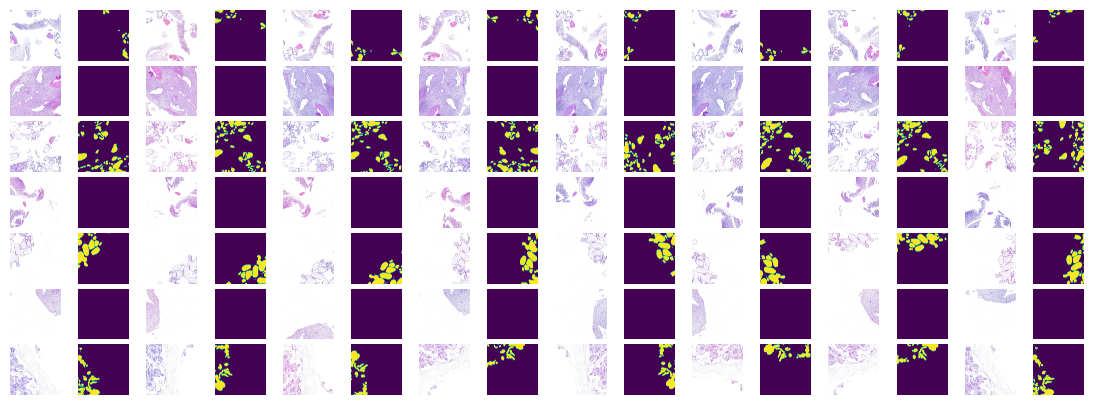

In [3]:
# parameters
datapath = 'D:\\Molar_pregnancy\\Aron_to_share\\Datasets'
dataname = 'data_villi_multi' 
log_dir = 'D:\\Molar_pregnancy\\Aron_to_share\\log' 
batch_size = 8 
n_process = 0 # adjust as needed
num_epochs = 100
depth = 5
wf = 3
up_mode = 'upconv'
conv_block = 'unet'

# unet params
n_classes = 3  # unlike classical unets, we have 3 classes
in_channels = 3 # It is RGB
padding = True
batch_norm = True

# training params
edge_weight = 1.1 
phases = ["train", "test"]
validation_phases = ["test"]
torch.backends.cudnn.benchmark = True 
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('mps') if torch.backends.mps.is_available() else torch.device('cpu')

# model
model = UNet(n_classes=n_classes, in_channels=in_channels, padding=padding, depth=depth, wf=wf, up_mode=up_mode, batch_norm=batch_norm).to(device)

# dataset
dataset = {}
dataLoader = {}
for phase in phases:
    dataset[phase] = Dataset(os.path.join(datapath, dataname) + f"_{phase}.pytable", device, transforms=randaugment_unet, edge_weight=edge_weight)
    dataLoader[phase] = DataLoader(dataset[phase], batch_size=batch_size, shuffle=True, num_workers=n_process, pin_memory=True, drop_last=True)

# visualize augmentations
fig, axes = plt.subplots(7, 8*2, figsize=(14, 5))
plt.subplots_adjust(wspace=0.1, hspace=0.1)
for i in range(7):
    for j in range(0, 8*2, 2):
        index = i
        img, mask, eweight = dataset['train'][index]
        axes[i, j].imshow(np.moveaxis(img.numpy(), 0, -1))
        axes[i, j].axis('off')
        axes[i, j+1].imshow(mask, vmin=0, vmax=2)
        axes[i, j+1].axis('off')

print(f"total params: \t{sum([np.prod(p.size()) for p in model.parameters()])}") 
summary_string = str(torchinfo.summary(model, input_size=torch.unsqueeze(dataset['train'][0][0], dim=0).shape, device=device, verbose=1)) 
# print(summary_string)

In [4]:

# prepare stuff for training (optimizer, weights, loss, confusion matrix, tensorboard)
optim = torch.optim.Adam(model.parameters()) 
class_weight = dataset["train"].numpixels[1, :]

f = np.sum(class_weight) / class_weight 
class_weight = f / np.sum(f)
class_weight = torch.from_numpy(class_weight).type('torch.FloatTensor').to(device) 
print(f'class weight: {class_weight}')

criterion = Criterion(class_weight, edge_weight) 

cm = ConfusionMatrix(task='multiclass', num_classes=3).to(device) 
writer = SummaryWriter(os.path.join(log_dir, f"unet_{dataname}_" + datetime.datetime.now().strftime("%Y-%m-%d_%Hh%M")))

# do the actual training
best_loss_on_test = np.inf
edge_weight = torch.tensor(edge_weight).to(device) 

start_time = time.time() # Start the time
for epoch in range(num_epochs):
    for phase in phases:

        stats = {}
        stats['loss'] = {}
        for stat in ['total_loss', 'crossEntropy_loss']:
            stats['loss'][stat] = 0 
        stats['cmatrix'] = torch.zeros((n_classes, n_classes)).to(device) 

        if phase == 'train':
            model.train()
        else:
            model.eval()
        
        for _, (X, y, y_weight) in enumerate(dataLoader[phase]):
            X = X.type('torch.FloatTensor').to(device, memory_format=torch.channels_last)
            y = y.type('torch.LongTensor').to(device)
            y_weight = y_weight.type('torch.FloatTensor').to(device)

            with torch.set_grad_enabled(phase == 'train'):

                x_pred = model(X)

                losses = criterion(x_pred, y, y_weight)
                loss = sum(losses)

                if phase == "train":
                    optim.zero_grad()
                    loss.backward()
                    optim.step()
                    train_loss = loss
                
                #Loss Logging
                stats['loss']['total_loss'] += loss.detach()
                stats['loss']['crossEntropy_loss'] += losses[0].detach()

                if phase in validation_phases:

                    predflat = x_pred.argmax(axis=1).flatten()
                    targetflat = y.flatten()

                    stats['cmatrix'] += cm(predflat, targetflat).detach()
                    #raw_cmatrix = stats['cmatrix'].cpu().numpy() ## Added by me

        n_batches = len(dataLoader[phase])
        stats['loss']['total_loss'] = (stats['loss']['total_loss']/n_batches).cpu().numpy()
        stats['loss']['crossEntropy_loss'] = (stats['loss']['crossEntropy_loss']/n_batches).cpu().numpy()

        if phase in validation_phases:
            stats['cmatrix'] = (stats['cmatrix'] / stats['cmatrix'].sum()).cpu().numpy() ## normalize

            # class_names = ['Background', 'Trophoblast', 'Stroma']
            # fig, ax = plt.subplots(figsize=(6, 5))
            # sns.heatmap(stats['cmatrix'], annot=True, fmt=".2f", xticklabels=class_names, yticklabels=class_names, cmap='Blues', ax=ax)
            # ax.set_xlabel('Predicted')
            # ax.set_ylabel('Actual')
            # ax.set_title(f'Confusion Matrix - {phase}')
            # plt.show()

        # save metrics to tensorboard
        writer.add_scalars(f'{phase}/loss', stats['loss'], epoch)
        if phase in validation_phases:
            for i in range(n_classes):
                TP = stats['cmatrix'][i, i]
                FP = stats['cmatrix'][:, i].sum() - TP
                FN = stats['cmatrix'][i, :].sum() - TP
                TN = stats['cmatrix'].sum() - (TP + FP + FN)

                precision = TP / (TP + FP + 1e-8)
                recall = TP / (TP + FN + 1e-8)
                specificity = TN / (TN + FP + 1e-8)
                npv = TN / (TN + FN + 1e-8)
                accuracy = (TP + TN) / (TP + TN + FP + FN + 1e-8)

                writer.add_scalar(f'{phase}/precision_class_{i}', precision, epoch)
                writer.add_scalar(f'{phase}/recall_class_{i}', recall, epoch)
                writer.add_scalar(f'{phase}/specificity_class_{i}', specificity, epoch)
                writer.add_scalar(f'{phase}/npv_class_{i}', npv, epoch)
                writer.add_scalar(f'{phase}/accuracy_class_{i}', accuracy, epoch)

        if phase == 'train':
            train_loss = stats['loss']['total_loss']
        current_loss = stats['loss']['total_loss']

    print('%s ([%d/%d] %d%%), train loss: %.4f test loss: %.4f' % (timeSince(start_time, (epoch + 1) / num_epochs),
                                                                   epoch + 1, num_epochs,
                                                                   (epoch + 1) / num_epochs * 100, train_loss,
                                                                   current_loss), end="")


    # if current loss is the best we've seen, save model state with all variables
    if current_loss < best_loss_on_test:
        best_loss_on_test = current_loss
        print("  **")
        state = {'epoch': epoch + 1,
                 'model_dict': model.state_dict(),
                 'optim_dict': optim.state_dict(),
                 'best_loss_on_test': current_loss,
                 'n_classes': n_classes,
                 'in_channels': in_channels,
                 'padding': padding,
                 'depth': depth,
                 'wf': wf,
                 'up_mode': up_mode,
                 'batch_norm': batch_norm,
                 'conv_block': conv_block}

        torch.save(state, f"D:\\Molar_pregnancy\\Aron_to_share\\Models\\{dataname}_best_model_multi_UNet.pth")

    else:
        print("")


class weight: tensor([0.0135, 0.8953, 0.0912], device='cuda:0')
0m 17s (- 28m 59s) ([1/100] 1%), train loss: 0.0380 test loss: 0.0443  **
0m 27s (- 22m 31s) ([2/100] 2%), train loss: 0.0300 test loss: 0.0338  **
0m 37s (- 20m 8s) ([3/100] 3%), train loss: 0.0270 test loss: 0.0362
0m 47s (- 18m 50s) ([4/100] 4%), train loss: 0.0247 test loss: 0.0385
0m 56s (- 18m 1s) ([5/100] 5%), train loss: 0.0227 test loss: 0.0220  **
1m 6s (- 17m 26s) ([6/100] 6%), train loss: 0.0199 test loss: 0.0211  **
1m 16s (- 16m 56s) ([7/100] 7%), train loss: 0.0195 test loss: 0.0187  **
1m 26s (- 16m 33s) ([8/100] 8%), train loss: 0.0196 test loss: 0.0271
1m 36s (- 16m 15s) ([9/100] 9%), train loss: 0.0177 test loss: 0.0283
1m 47s (- 16m 5s) ([10/100] 10%), train loss: 0.0168 test loss: 0.0203
1m 58s (- 15m 56s) ([11/100] 11%), train loss: 0.0186 test loss: 0.0151  **
2m 9s (- 15m 48s) ([12/100] 12%), train loss: 0.0169 test loss: 0.0164
2m 19s (- 15m 35s) ([13/100] 13%), train loss: 0.0157 test loss: 0.0156

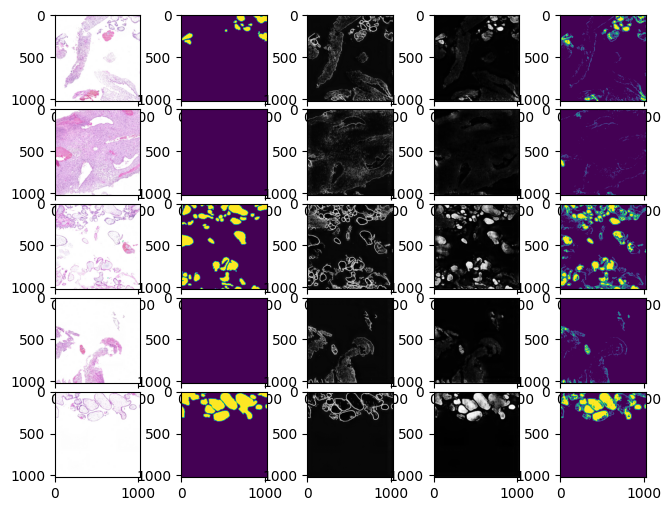

In [5]:
# visualize on tables without augmentations (for instance on the training set to better see what the model is learning)

fig, axes = plt.subplots(min(5, len(dataset['train'])), 5, figsize=(8, 6), num= 5)
plt.subplots_adjust(wspace=0.1, hspace=0.1)

for i in range(min(5, len(dataset['train']))):
    model.eval()
    with tables.open_file(dataset['train'].fname, 'r') as db:
        img = db.root.img[i]
        mask = db.root.mask[i]
    img = img / 255

    img_gpu = torch.from_numpy(img).permute(2, 0, 1)
    img_gpu = torch.unsqueeze(img_gpu, dim=0).type(torch.float32).to(device, memory_format=torch.channels_last)
    unet_out = torch.squeeze(model(img_gpu), dim=0)

    axes[i, 0].imshow(img)
    axes[i, 1].imshow(mask, vmin=0, vmax=2)
    axes[i, 2].imshow(torch.nn.Softmax(dim=0)(unet_out)[1, :, :].detach().cpu().numpy(), cmap='gray', vmin=0, vmax=1)
    axes[i, 3].imshow(torch.nn.Softmax(dim=0)(unet_out)[2, :, :].detach().cpu().numpy(), cmap='gray', vmin=0, vmax=1)
    axes[i, 4].imshow(np.argmax(unet_out.detach().cpu().numpy(), axis=0), vmin=0, vmax=2)
